<a href="https://colab.research.google.com/github/ACfma/CMEPDA_exam/blob/main/CNN_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolution Neural Network for classify the image obtained from the brain MRIs of a cohort of subjects with Alzheimer’s disease and control subjects.

Martina Moglioni, MAT. 606469

#Introduction

Semantic Segmentation is a classic Computer Vision problem which involves taking as input some raw data (e.g. 2D or 3D images) and converting them into a mask with regions of interest highlighted.

**Objective**: We trained an Auto-Encoder (AE) to compress the grey matter image segments obtained from the brain MRIs of a cohort of subjects with Alzheimer's disease and control subjects.

We used the dataset made available at:

https://drive.google.com/drive/u/1/folders/1KfFF_ww-MW9z1B-pGaa-qBtSpfy-ckUJ

**Dataset**: Images of the brain MRIs avaible are split in two folder, one (AD_s3) for patients with Alzheimer's disease, and the other one (CTRL_s3) for control subjects. *Due to the huge size of the dataset we worked on one or few slices crossing the hippocampus.*

# Reading Data from GoogleDrive




First step is reading dataset avaible at this link: 

https://drive.google.com/drive/u/1/folders/1KfFF_ww-MW9z1B-pGaa-qBtSpfy-ckUJ

Unzip the folder and then classified dataset in two path: 
*   dataset_path_AD for patients with Alzheimer's disease;
*   dataset_path_CTRL for control subjects.


In [139]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [140]:
dataset_path_AD = '/gdrive/MyDrive/AD_CTRL/AD_s3'
dataset_path_CTRL = '/gdrive/MyDrive/AD_CTRL/CTRL_s3'

For the CNN we use an only folder with all files

In [141]:
all_data_path = '/gdrive/MyDrive/AD_CTRL/ALL_FILES'

# Dataset overview, loading data

Mounted dataset from GoogleDrive is now possible to "see" the images of the brain MRIs. 
File format is ble bla bla


In [142]:
! pip install SimpleITK

In [143]:
import os
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import glob
import nibabel as nib
from skimage.io import imread

Loading the data: We will use glob module which will return a list comprising of all the volumes in the folder that we heve just specify as "all_data_path".

In [144]:
ff = glob.glob(os.path.join(all_data_path, '*.nii'))

Now we can load the 3D volumes using nibabel. Note that when you load a Nifti format volume, Nibabel does not load the image array. It waits until you ask for the array data. The normal way to ask for the array data is to call the get_fdata() method.

We want the 2D slices instead of 3D, so we initialise a list in which; every time we read a volume, we will iterate over all the complete slices of the 3D volume and append each slice one by one in to a list.

In [145]:
images = []
for f in range(len(ff)):
    a = nib.load(ff[f])
    a = a.get_fdata()
    a = a[:,40:60,:]
    for i in range(a.shape[1]):
        images.append((a[:,i,:]))
print (a.shape)

(121, 20, 121)


Since images is a list we use numpy module to convert the list in to a numpy array.
It's time to check the shape of the numpy array, the first dimension of the array should be 145 x 333 respectively and the remaining two dimensions will be 121 x 121.
Selecting only 20 slices we have the first dimension as 20x333.

The images of the dataset are indeed grayscale images with a dimension of 121 x 121 so before we feed the data into the model it is very important to preprocess it. We first convert each 121 x 121 image into a matrix of size 121 x 121 x 1, which we can feed into the network:



In [146]:
images = np.asarray(images)
print(images.shape)

(6660, 121, 121)


In [147]:
images = images.reshape(-1, 121,121,1)
images.shape

(6660, 121, 121, 1)

 Rescale the data with using max-min normalisation technique:

In [148]:
m = np.max(images)
mi = np.min(images)

In [149]:
images = (images - mi) / (m - mi)

After all of this, it's important to partition the data. We split the data into two parts: a training and a test set. We will train your model on 80% of the data and test it on 20% of the remaining training data.

This will probably help us in reducing the chances of overfitting, as we will be testing our model on data it would not have seen in training phase.

We use the train_test_split module of scikit-learn to divide the data properly:

In [150]:
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation
from keras.models import Sequential

x_train, x_test, y_train, y_test = train_test_split(images, images, test_size=0.2, random_state=13)

Our training images will both act as the input as well as the ground truth similar to the labels we have in classification task.

Let's now analyze how images in the dataset look like and also see the dimension of the images once again.

In [151]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5328, 121, 121, 1) (5328, 121, 121, 1)
(1332, 121, 121, 1) (1332, 121, 121, 1)


For feed the network we reshape our labels (y) as 2d-tensor (the first dimension will be the batch dimension and the second the scalar label):

In [152]:
y_train = np.asarray(x_train).astype('float32').reshape((-1,1))
y_test = np.asarray(x_test).astype('float32').reshape((-1,1))

In [153]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(5328, 121, 121, 1) (78007248, 1)
(1332, 121, 121, 1) (19501812, 1)


Let's take a look at couple of the training and testing images in our dataset:

Dataset (images) shape: (6660, 121, 121, 1)


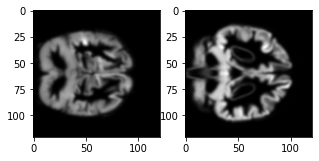

In [154]:
print("Dataset (images) shape: {shape}".format(shape=images.shape))

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[0], (121,121))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test[0], (121,121))
plt.imshow(curr_img, cmap='gray')

#Defining a CNN model

In [155]:
def make_model(shape=(121, 121, 1)):
  model = Sequential([
      
      Conv2D(64, (3,3), padding='same', input_shape=shape),
      Activation('relu'),
      BatchNormalization(),
      
      MaxPool2D((2,2)),
      
      Conv2D(128, (3,3), padding='same'),
      Activation('relu'),
      BatchNormalization(),
 
      MaxPool2D((2,2)),
        
      Conv2D(512, (3,3), padding='same'),
      Activation('relu'),
      BatchNormalization(),
      
      Flatten(), 
      Dense(1, activation='sigmoid')
  ])
  
  return model

After the model is created, we compile it using the optimizer to be SGD.

Let's visualize the layers that we created in the above step by using the summary function, this will show number of parameters (weights and biases) in each layer and also the total parameters in our model.

In [156]:
model = make_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 121, 121, 64)      640       
_________________________________________________________________
activation_21 (Activation)   (None, 121, 121, 64)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 121, 121, 64)      256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
activation_22 (Activation)   (None, 60, 60, 128)       0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 60, 60, 128)      

In [157]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [158]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

It's finally time to train the model with Keras'fit() function. The model trains for 10 epochs. The fit() function will return a history object. 

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, shuffle=True, callbacks=[checkpoint])

Epoch 1/10
 42/134 [========>.....................] - ETA: 5:52 - loss: 18.6156 - accuracy: 0.1442

Let's visualize the model perfomance with a plot.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label ='loss')
plt.plot(history.history['val_loss'], label ='val_loss')
plt.legend()
plt.grid()
plt.figure()
plt.plot(history.history['val_accuracy'], label ='val_accuracy')
plt.plot(history.history['accuracy'], label ='accuracy')
plt.legend()
plt.grid()